# Building the basic MIMIC feautre matrix for NLD work.

* We take minimum and maximum values of each variable during four hour sample window (four hours prior to callout)
* For 'single_feature_variables' we take only the final value (variables which are infrequently recorded will have the same value for min and max and therefore using both min and max as features for these variables does not make sense).
* We find that there are a lot of missing values when using the four hour sample window. So, where values are missing we look back over an extended sample window of 36 hours and take the final value during that time as the feature value.
* The above procedure results in imbalanced class sizes (there are relatively few patients with negative outcomes following callout). To balance the class sizes we sample from icustays using the same method described above, but at a sample time that is an integer multiple of 24 hours prior to callout (but not within 24 hours of icu admission). We specify that this sample must be taken at least 72 hours prior to callout, under the assumption that a patient is deintitely not ready for discharge at this point in time.
* These extra instances of the negative class are assigned unique identifier and treated as separate patients, however we save the id mapping so we can tell which stay each sample was taken from and at what time point.

#### First we configure this script:

In [1]:
DATA_PATH = 'all_cleaned_with_callouts.pickle'   ## where the data we previously extracted and cleaned up from mimic is stored
SAVE_FLAG = True    ## allows running this script without autmatically overwriting previous feature matrices
HOURS_BEFORE_RFD = 4    ## original sample window (four hours specified by NLD)
MAXIMUM_LOOKBACK = 48   ## extension to sample window when no value recorded in original window (final valule taken)

## variables for which to only use single feature column:
single_feature_variables = ['k', 'na', 'bun', 'creatinine', 'hco3', 'haemoglobin', 'fio2', 'airway', 'pco2', 'po2', 'pain']

In [2]:
#import graphlab
import pandas as pd
import numpy as np
import pickle
import datetime
import shutil
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from tqdm import tqdm
#import graphlab.aggregate as agg
%matplotlib inline

#### Load the data that we have previously extracted and pre-processed from MIMIC:

In [3]:
all_data = pd.read_pickle(DATA_PATH)

#### Create an SFrame to store summary of missing data:

#### Select only measurments taken in HOURS_BEFORE_DISCHARGE:

In [4]:
all_data = all_data[all_data['hrs_bRFD']<=HOURS_BEFORE_RFD]
all_data = all_data[all_data['hrs_bRFD']>=0]
print( "There are %d icu satys with variables recorded in the final %d hours before CALLOUT." %(len(all_data['C.ICUSTAY_ID'].unique()),HOURS_BEFORE_RFD))

There are 11269 icu satys with variables recorded in the final 4 hours before CALLOUT.


#### Produce data summary:

In [5]:
summary = all_data.groupby(by='C.ICUSTAY_ID').aggregate({'outcome':'min',
                                                                     'cohort':'min',
                                                                     'readmit':'min',
                                                                     'in_h_death':'min',
                                                                     'in_icu_death':'min',
                                                                     'II.LOS':'min',
                                                                     'II.OUTTIME':'min',
                                                                     'II.INTIME':'min'
                                                                    }).reset_index()

print( "There are %d icu stays in the cohort." %sum(summary['cohort']==1))
cohort_summary = summary[summary['cohort']==1]

There are 10651 icu stays in the cohort.


#### We now begin to construct the feature matrix.

In [6]:
features = all_data.groupby(by=['C.ICUSTAY_ID', 'VARIABLE'],as_index=False).agg(
                            min_v=('C.VALUENUM', 'min'),
                            max_v=('C.VALUENUM', 'max'),
                            values=('C.VALUENUM', list),
                            count=('C.VALUENUM', 'count'),
                            cohort=('cohort', 'min'),
                            outcome=('outcome','min'))

In [7]:
features = features.sort_values(by='C.ICUSTAY_ID',ascending=True)


#### We define a function that takes the above dataframe and splits it into feature columns:

In [8]:
def _split_features_to_columns(features, single_feature_vars=single_feature_variables):
    ''' Note: sort features by ICUSTAY_ID before using this function.'''
    
    all_variables = features['VARIABLE'].unique()
    all_stay_ids = features['C.ICUSTAY_ID'].unique()
    
    thisFM = pd.DataFrame()
    thisFM['ICUSTAY_ID'] = all_stay_ids
    
    for var in all_variables:
        print( var)

        var_min = []
        var_max = []
        var_values = []
        var_count = []

        _subset = features[features['VARIABLE']==var]
        N = len(_subset)-1

        rid = 0
        for sid in all_stay_ids:
            if rid<=N and _subset.iloc[rid]['C.ICUSTAY_ID']==sid:
                ## add data and move on a row
                row = _subset.iloc[rid]
                var_min.append(row['min_v'])
                var_max.append(row['max_v'])
                var_values.append(row['values'])
                rid += 1
            else:
                ## add None values and stay in place
                var_min.append(None)
                var_max.append(None)
                var_values.append([])

        if var not in single_feature_vars:
            thisFM[var + '_min'] = var_min
            thisFM[var + '_max'] = var_max
    
        else:
            ## if it is a single variable feature - take final value only
            thisFM[var] = [val[-1]  if len(val)>0 else None for val in var_values]
        
    return thisFM

In [9]:
FM = _split_features_to_columns(features, single_feature_variables)

bp
gcs
hr
resp
spo2
temp
pain
fio2
na
k
hco3
creatinine
bun
haemoglobin
po2
pco2
airway


#### How many missing values are there in this feature matrix?

In [10]:
FM['gcs_min'].unique()

array([ 4.,  1.,  3., nan,  2.,  5.,  6.])

In [11]:
nrows = float(len(FM))

missing_data = pd.DataFrame()
vname = []
miss_freq = []

for col in FM.columns:
    vname.append(col) 
    miss_freq.append(sum(FM[col].isna())/nrows)
        
missing_data['variable'] = vname
missing_data['fraction missing'] = miss_freq

missing_data = missing_data.sort_values(by='fraction missing', ascending=True)
missing_data.head(25)

,variable,fraction missing
0,ICUSTAY_ID,0.000000
5,hr_min,0.001686
6,hr_max,0.001686
7,resp_min,0.006034
8,resp_max,0.006034
1,bp_min,0.006655
2,bp_max,0.006655
10,spo2_max,0.011270
9,spo2_min,0.011270
12,temp_max,0.074186


#### Some variables have a very high frequency of missing values. We decided to improve this by relaxing the 4 hour measurement window of the NLD criteria - SEE BLEOW. In some cases (e.g. laboratory results) this is clearly too short a window and is producing lots of missingness. 

In [12]:
missing_data_summary = pd.DataFrame()
missing_data_summary['variable'] = missing_data['variable']
missing_data_summary = missing_data_summary.merge(missing_data,how='right',on='variable')
missing_data_summary = missing_data_summary.rename(columns={'fraction missing':'mimic_4hr'})

In [13]:
missing_data_summary

,variable,mimic_4hr
0,ICUSTAY_ID,0.000000
1,hr_min,0.001686
2,hr_max,0.001686
3,resp_min,0.006034
4,resp_max,0.006034
5,bp_min,0.006655
6,bp_max,0.006655
7,spo2_max,0.011270
8,spo2_min,0.011270
9,temp_max,0.074186


#### Here we fill airway since absence -> no ETT at this time and therefore patent airway:

In [14]:
FM_filled = FM.copy()
FM_filled['airway'] = FM_filled['airway'].fillna(value=0.0)

#### We construct a table with the final value before CALLOUT for each variable for each stay:

In [15]:
all_data = pd.read_pickle(DATA_PATH)
all_data = all_data[all_data['hrs_bRFD']>=0]
all_data = all_data[all_data['C.ICUSTAY_ID'].isin(FM_filled['ICUSTAY_ID'])]

In [16]:
def agg_func(data, stay_id, var):
    series = {}
    series['C.ICUSTAY_ID'] = stay_id
    series['VARIABLE'] = var
    series['hrs_bRFD'] = data.loc[data['C.CHARTTIME'].idxmax()]['hrs_bRFD']
    series['C.VALUENUM'] = data.loc[data['C.CHARTTIME'].idxmax()]['C.VALUENUM']
    return pd.Series(series)

final_values_grouped = all_data.groupby(by=['C.ICUSTAY_ID', 'VARIABLE'], as_index=False)
final_values = []
for (stay_id, var), group in tqdm(final_values_grouped):
    final_values.append(agg_func(group, stay_id, var))

final_values = pd.DataFrame(final_values)
final_values

100%|██████████| 161148/161148 [00:47<00:00, 3426.72it/s]


,C.ICUSTAY_ID,VARIABLE,hrs_bRFD,C.VALUENUM
0,200001,bp,0.110000,110.0000
1,200001,bun,8.343333,20.7118
2,200001,creatinine,8.343333,256.4180
3,200001,fio2,53.126667,35.0000
4,200001,gcs,2.276667,4.0000
...,...,...,...,...
161143,299998,pco2,15.154167,4.9321
161144,299998,po2,15.154167,22.3944
161145,299998,resp,1.237500,12.0000
161146,299998,spo2,1.237500,100.0000


In [17]:
final_values = final_values[final_values['hrs_bRFD']<=MAXIMUM_LOOKBACK]
final_values = final_values[final_values['hrs_bRFD']>=HOURS_BEFORE_RFD]

In [18]:
final_values = final_values.sort_values(ascending=True, by=['VARIABLE', 'C.ICUSTAY_ID'])

In [19]:
vars_to_use_fv = [var for var in final_values['VARIABLE'].unique()]

In [20]:
FM_filled = FM_filled.sort_values(ascending=True, by='ICUSTAY_ID')

In [21]:
FM_filled_copy = FM_filled.copy()

In [22]:
FM_filled = FM_filled_copy.copy()

#### We now replace missing values (from four hour window) with final values from the extended window (where available):

In [23]:
def replace_missing_value(subset, variable, FM_filled, N, vtype='min'):
    
    if vtype=='min':
        suffix = '_min'
    elif vtype=='max':
        suffix = '_max'
    elif vtype=='single':
        suffix = ''
        
    new_col = []
    _subset_row_counter = 0
    for iid,val, val_is_nan in zip(FM_filled['ICUSTAY_ID'], FM_filled[variable+suffix], FM_filled[variable+suffix].isna()):

        if val_is_nan:
            if _subset_row_counter<=N and subset.iloc[_subset_row_counter]['C.ICUSTAY_ID']==iid:
                new_col.append(subset.iloc[_subset_row_counter]['C.VALUENUM'])
                _subset_row_counter += 1
            else:
                new_col.append(None)
        else:
            new_col.append(val)

    FM_filled[variable+suffix] = new_col
    return FM_filled


for variable in vars_to_use_fv:
    print(variable)
    _subset = final_values[final_values['VARIABLE']==variable]
    _subset = _subset.reset_index()
    _subset = _subset.sort_values(by='C.ICUSTAY_ID', ascending=True)
    N = len(_subset)-1
    
    if variable not in single_feature_variables:
        FM_filled = replace_missing_value(_subset, variable, FM_filled, N, vtype='min')
        FM_filled = replace_missing_value(_subset, variable, FM_filled, N, vtype='max')
    
    else:
        FM_filled = replace_missing_value(_subset, variable, FM_filled, N, vtype='single')

airway
bp
bun
creatinine
fio2
gcs
haemoglobin
hco3
hr
k
na
pain
pco2
po2
resp
spo2
temp


In [24]:
len(FM_filled), len(FM_filled['ICUSTAY_ID'].unique())

(11269, 11269)

In [25]:
stayids = FM_filled[FM_filled['temp_min'].isna()]['ICUSTAY_ID']
len(final_values[(final_values['C.ICUSTAY_ID'].isin(stayids)) & (final_values['VARIABLE']=='temp')]['C.VALUENUM'])

142

In [26]:
len(final_values[(final_values['VARIABLE']=='temp') & (final_values['hrs_bRFD']>4)]), sum(final_values[(final_values['VARIABLE']=='temp') & (final_values['hrs_bRFD']>4)]['C.VALUENUM'].isna())

(417, 142)

In [27]:
final_values[final_values['VARIABLE']=='temp']['VARIABLE'].isna().unique(), len(FM_filled)

(array([False]), 11269)

In [28]:
final_values[final_values['VARIABLE']=='temp']['hrs_bRFD'].max()

32.76138888888889

In [29]:
sum(FM['temp_min'].isna()), sum(FM_filled['temp_min'].isna()) 

(836, 561)

#### We see that this has improved the missingness for most variables:

In [30]:
nrows = float(len(FM_filled))
for col in FM_filled.columns:
    print('%s : %.3f' %(col, sum(FM_filled[col].isna())/nrows))

ICUSTAY_ID : 0.000
bp_min : 0.000
bp_max : 0.000
gcs_min : 0.001
gcs_max : 0.001
hr_min : 0.000
hr_max : 0.000
resp_min : 0.001
resp_max : 0.001
spo2_min : 0.001
spo2_max : 0.001
temp_min : 0.050
temp_max : 0.050
pain : 0.169
fio2 : 0.653
na : 0.015
k : 0.015
hco3 : 0.016
creatinine : 0.017
bun : 0.017
haemoglobin : 0.022
po2 : 0.733
pco2 : 0.733
airway : 0.000


### discrepency in temperature missing values 0.05 vs 0.002

In [31]:
missing_data_summary['mimic_36hr'] = missing_data_summary.apply(lambda row: sum(FM_filled[row['variable']].isna())/nrows if row['variable']!='ICUSTAY_ID' else 0.0, axis=1) 

In [32]:
missing_data_summary

,variable,mimic_4hr,mimic_36hr
0,ICUSTAY_ID,0.000000,0.000000
1,hr_min,0.001686,0.000355
2,hr_max,0.001686,0.000355
3,resp_min,0.006034,0.000799
4,resp_max,0.006034,0.000799
5,bp_min,0.006655,0.000355
6,bp_max,0.006655,0.000355
7,spo2_max,0.011270,0.000532
8,spo2_min,0.011270,0.000532
9,temp_max,0.074186,0.049783


In [33]:
_sum_sub = summary[['C.ICUSTAY_ID', 'cohort', 'outcome']]
_sum_sub = _sum_sub.rename(columns={'C.ICUSTAY_ID':'ICUSTAY_ID'})
FM_filled2 = FM_filled.merge(how='inner', on='ICUSTAY_ID', right=_sum_sub)

#### We now have a feature matrix. However, the class sizes are highly imbalanced. We decided to balance the class sizes by creating more instances of the negative class. We do this by sampling the patients at integer multiples of 24 hours prior to their CALLOUT.

In [34]:
all_data = pd.read_pickle(DATA_PATH)

We look at how many stays are available at Xi days prior to callout, and how many extra samples would be required to balance the class sizes:

In [35]:
_stay_summary = all_data.groupby(by='C.ICUSTAY_ID', as_index=False).aggregate(
                                                                            outcome=('outcome', 'min'),
                                                                            RFD=('RFD', 'min'),
                                                                            intime=('II.INTIME','min'))
_stay_summary['len'] = (_stay_summary['RFD'] - _stay_summary['intime']).apply(lambda row: row.total_seconds()/(60*60))

In [36]:
_stay_summary['len']

0        64.173333
1        11.731944
2        18.874722
3        71.721389
4        21.363889
           ...    
11283     9.834444
11284    17.901667
11285    44.765000
11286    31.862222
11287    24.443056
Name: len, Length: 11288, dtype: float64

In [37]:
fx = lambda x:24*x + 4

In [38]:
_stays = []
for i in range(10):
    _stays.append(sum(_stay_summary['len'] >= fx(i)))

In [39]:
num_rfd0 = sum(FM_filled2['outcome'])
num_nrfd0 = len(FM_filled2['outcome']) - num_rfd0

print( num_rfd0)
print( num_nrfd0)
print( "We would need at least %d extra samples to balance the classes." %(num_rfd0 - num_nrfd0))

9640
1629
We would need at least 8011 extra samples to balance the classes.


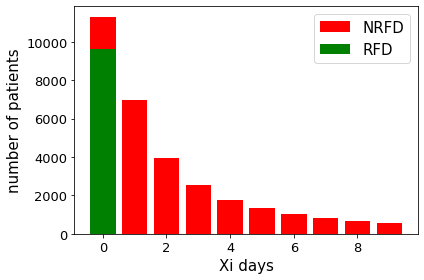

In [40]:
fsa = 15

plt.bar(range(10), _stays, color='r', label='NRFD')
ax = plt.gca()
ax.bar(0,num_rfd0, color='g', label='RFD')
plt.legend(fontsize=fsa)
plt.xlabel('Xi days', fontsize=fsa)
plt.ylabel('number of patients', fontsize=fsa)
plt.xticks(fontsize=fsa-2)
plt.yticks(fontsize=fsa-2)

plt.tight_layout()
plt.savefig('mimic_negex_bars.png')

#### We determine that sampling at Xi in (3-8) will provide more than enough extra NRFD instances.

In [41]:
def sample_at_xi(_all_data, _summary, xi=3, h=4):
    ## selects stays to include in negative extras
    ## xi is integer number of days before RFD flag
    ## h is sample window length (4 hours is NLD standard)
    ##      new: only stays that are at least (xi+1)*24 hours long are included
    ##           so that sample point does not fall within 24 hours of ICU admission (thanks to reviewer 2) 
    
    sids = _summary[_summary['len']>= fx(xi + 1)]['C.ICUSTAY_ID']  ## added +1 to filter out sample points that would be witin 24 hours of admission to ICU
    sub_data = _all_data[_all_data['C.ICUSTAY_ID'].isin(sids)]
    
    sub_data = sub_data[sub_data['hrs_bRFD']>= 24*xi]
    sub_data = sub_data[sub_data['hrs_bRFD']<= 24*xi + h]
    return sub_data

In [42]:
Xi_range = [3,4,5,6,7,8]
H = 4
fx = lambda x:24*x + H

for Xi in Xi_range:
    
    sub_data = sample_at_xi(all_data, _stay_summary, Xi, H)
    print( "Xi = %d, ns = %d" %(Xi, len(sub_data['C.ICUSTAY_ID'].unique())))

Xi = 3, ns = 1776
Xi = 4, ns = 1317
Xi = 5, ns = 1035
Xi = 6, ns = 845
Xi = 7, ns = 675
Xi = 8, ns = 537


### Original division
Xi = 3, ns = 1774

Xi = 4, ns = 1315

Xi = 5, ns = 1033

Xi = 6, ns = 844

Xi = 7, ns = 674

Xi = 8, ns = 537

In [43]:
print("The lowest ICUSTAY_ID in the dataset is: %d." %min(all_data['C.ICUSTAY_ID']))

The lowest ICUSTAY_ID in the dataset is: 200001.


#### We create a one-to-one ID mapping so we can unqileuy identify which patient each new sample comes from:

In [44]:
id_mapping = pd.DataFrame()
largest_id = max(all_data['C.ICUSTAY_ID'])

for Xi in Xi_range:
    sub_data = sample_at_xi(all_data, _stay_summary, Xi, H)
    
    L = len(sub_data['C.ICUSTAY_ID'].unique())
    _temp_id_mapping = pd.DataFrame()
    _temp_id_mapping['Xi'] = Xi * np.ones(L)
    _temp_id_mapping['ICUSTAY_ID'] = sub_data['C.ICUSTAY_ID'].unique()
    id_mapping = id_mapping.append(_temp_id_mapping)

id_mapping['new_ID'] = np.arange(len(id_mapping))

/var/folders/0b/yktjm4xd46bglcgmv_ltqv900000gn/T/ipykernel_25221/3750903148.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_mapping = id_mapping.append(_temp_id_mapping)
/var/folders/0b/yktjm4xd46bglcgmv_ltqv900000gn/T/ipykernel_25221/3750903148.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_mapping = id_mapping.append(_temp_id_mapping)
/var/folders/0b/yktjm4xd46bglcgmv_ltqv900000gn/T/ipykernel_25221/3750903148.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  id_mapping = id_mapping.append(_temp_id_mapping)
/var/folders/0b/yktjm4xd46bglcgmv_ltqv900000gn/T/ipykernel_25221/3750903148.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

In [45]:
id_mapping

,Xi,ICUSTAY_ID,new_ID
0,3.0,281232,0
1,3.0,237570,1
2,3.0,250529,2
3,3.0,281513,3
4,3.0,262259,4
...,...,...,...
532,8.0,237729,6180
533,8.0,229184,6181
534,8.0,268051,6182
535,8.0,293763,6183


In [46]:
if SAVE_FLAG:
    id_mapping.to_pickle('mimic_negative_extras_id_mapping2.pickle')

#### Get features for the new samples at Xi = [3,4,5,6,7,8]:

In [47]:
def get_Xi_features(Xi, all_data, _stay_summary, id_mapping, H=4):
    
    sub_data = sample_at_xi(all_data, _stay_summary, Xi, H)
    ## now get features from subset of data:
    features = sub_data.groupby(by=['C.ICUSTAY_ID', 'VARIABLE'], as_index=False).aggregate( 
                                            min_v=('C.VALUENUM', 'min'),
                                            max_v=('C.VALUENUM', 'max'),
                                            mean=('C.VALUENUM', 'mean'),
                                            var=('C.VALUENUM', 'var'),
                                            times=('C.CHARTTIME', list),
                                            values=('C.VALUENUM', list),
                                            count=('C.VALUENUM','count'),
                                            cohort=('cohort', 'min'),
                                            outcome=('outcome', 'min')
                                            )

    ids = id_mapping[id_mapping['Xi']==float(Xi)]
    features = features.rename(columns={'C.ICUSTAY_ID': 'ICUSTAY_ID'})
    print(ids.columns)
    print(features.columns)
    features = features.merge(right=ids, on='ICUSTAY_ID', how='inner')

    features = features.drop(columns='ICUSTAY_ID')
    features = features.rename(columns={'new_ID': 'C.ICUSTAY_ID'})

    features = features.sort_values(ascending=True, by='C.ICUSTAY_ID')

    _temp_FM = _split_features_to_columns(features)
    return _temp_FM


In [48]:
_FM_negative = get_Xi_features(Xi_range[0], all_data, _stay_summary, id_mapping)

for Xi in Xi_range[1:]:
    print( Xi)
    _temp_FM = get_Xi_features(Xi, all_data, _stay_summary, id_mapping)
    _FM_negative = _FM_negative.append(_temp_FM)

Index(['Xi', 'ICUSTAY_ID', 'new_ID'], dtype='object')
Index(['ICUSTAY_ID', 'VARIABLE', 'min_v', 'max_v', 'mean', 'var', 'times',
       'values', 'count', 'cohort', 'outcome'],
      dtype='object')
temp
spo2
resp
hr
gcs
bp
fio2
airway
pain
k
na
hco3
bun
creatinine
pco2
po2
haemoglobin
4
Index(['Xi', 'ICUSTAY_ID', 'new_ID'], dtype='object')
Index(['ICUSTAY_ID', 'VARIABLE', 'min_v', 'max_v', 'mean', 'var', 'times',
       'values', 'count', 'cohort', 'outcome'],
      dtype='object')
pain
spo2
resp
temp
hr
gcs
fio2
airway
bp
po2
pco2
na
k
hco3
haemoglobin
creatinine
bun
5


/var/folders/0b/yktjm4xd46bglcgmv_ltqv900000gn/T/ipykernel_25221/1860856144.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _FM_negative = _FM_negative.append(_temp_FM)


Index(['Xi', 'ICUSTAY_ID', 'new_ID'], dtype='object')
Index(['ICUSTAY_ID', 'VARIABLE', 'min_v', 'max_v', 'mean', 'var', 'times',
       'values', 'count', 'cohort', 'outcome'],
      dtype='object')
fio2
gcs
hr
spo2
temp
resp
airway
bp
po2
pco2
k
pain
na
bun
creatinine
haemoglobin
hco3
6


/var/folders/0b/yktjm4xd46bglcgmv_ltqv900000gn/T/ipykernel_25221/1860856144.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _FM_negative = _FM_negative.append(_temp_FM)


Index(['Xi', 'ICUSTAY_ID', 'new_ID'], dtype='object')
Index(['ICUSTAY_ID', 'VARIABLE', 'min_v', 'max_v', 'mean', 'var', 'times',
       'values', 'count', 'cohort', 'outcome'],
      dtype='object')
resp
hco3
haemoglobin
gcs
fio2
creatinine
bp
bun
hr
k
na
pain
temp
spo2
po2
airway
pco2
7


/var/folders/0b/yktjm4xd46bglcgmv_ltqv900000gn/T/ipykernel_25221/1860856144.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _FM_negative = _FM_negative.append(_temp_FM)


Index(['Xi', 'ICUSTAY_ID', 'new_ID'], dtype='object')
Index(['ICUSTAY_ID', 'VARIABLE', 'min_v', 'max_v', 'mean', 'var', 'times',
       'values', 'count', 'cohort', 'outcome'],
      dtype='object')
temp
spo2
resp
pain
hr
gcs
fio2
bp
hco3
k
na
po2
creatinine
airway
pco2
bun
haemoglobin
8


/var/folders/0b/yktjm4xd46bglcgmv_ltqv900000gn/T/ipykernel_25221/1860856144.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _FM_negative = _FM_negative.append(_temp_FM)


Index(['Xi', 'ICUSTAY_ID', 'new_ID'], dtype='object')
Index(['ICUSTAY_ID', 'VARIABLE', 'min_v', 'max_v', 'mean', 'var', 'times',
       'values', 'count', 'cohort', 'outcome'],
      dtype='object')
bp
spo2
fio2
gcs
hr
temp
resp
airway
pain
k
na
hco3
haemoglobin
creatinine
bun
pco2
po2


/var/folders/0b/yktjm4xd46bglcgmv_ltqv900000gn/T/ipykernel_25221/1860856144.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _FM_negative = _FM_negative.append(_temp_FM)


In [47]:
all_data.drop??

#### How much missing data?

In [49]:
nrows = float(len(_FM_negative))

missing_data = pd.DataFrame()
vname = []
miss_freq = []

for col in _FM_negative.columns:
    vname.append(col)
    miss_freq.append(sum(_FM_negative[col].isna())/nrows)
        
missing_data['variable'] = vname
missing_data['fraction missing'] = miss_freq

missing_data = missing_data.sort_values(by='fraction missing', ascending=True)
missing_data.head(25)

,variable,fraction missing
0,ICUSTAY_ID,0.000000
8,hr_max,0.001940
7,hr_min,0.001940
12,bp_max,0.003072
11,bp_min,0.003072
3,spo2_min,0.004204
4,spo2_max,0.004204
5,resp_min,0.004689
6,resp_max,0.004689
2,temp_max,0.049636


In [50]:
missing_data_summary = missing_data_summary.merge(how='inner', on='variable', right=missing_data)
missing_data_summary = missing_data_summary.rename(columns={'fraction missing':'mimic_negex_4hour'})

#### Fill the missing data:

In [51]:
_FM_negative_filled = _FM_negative.copy()
_FM_negative_filled['airway'] = _FM_negative_filled['airway'].fillna(value=0.0)

In [52]:
def fill_with_final_values(FM_filled, Xi, new_icustays):
    
    all_data = pd.read_pickle(DATA_PATH)
    all_data = all_data[all_data['hrs_bRFD'] >= 24*Xi]
    
    new_icustays = new_icustays.rename(columns={'ICUSTAY_ID':'C.ICUSTAY_ID'})
    all_data = all_data.merge(right=new_icustays, on='C.ICUSTAY_ID', how='inner')
    all_data = all_data.drop(columns='C.ICUSTAY_ID')
    all_data = all_data.rename(columns={'new_ID':'C.ICUSTAY_ID'})
    
    final_values_grouped = all_data.groupby(by=['C.ICUSTAY_ID', 'VARIABLE'], as_index=False)
    final_values = []
    for (stay_id, var), group in tqdm(final_values_grouped):
        final_values.append(agg_func(group, stay_id, var))
    final_values = pd.DataFrame(final_values)

    final_values = final_values[final_values['hrs_bRFD'] <= MAXIMUM_LOOKBACK + (24*Xi)]
    final_values = final_values[final_values['hrs_bRFD'] > H + (24*Xi)]
    
    final_values = final_values.sort_values(ascending=True, by=['VARIABLE', 'C.ICUSTAY_ID'])
    vars_to_use_fv = [var for var in final_values['VARIABLE'].unique()] 
    FM_filled = FM_filled.sort_values(ascending=True, by='ICUSTAY_ID')
    
    for variable in vars_to_use_fv:
        print( variable)

        _subset = final_values[final_values['VARIABLE']==variable]
        _subset = _subset.sort_values(by='C.ICUSTAY_ID', ascending=True)
        N = len(_subset)-1
        
        if variable not in single_feature_variables:
            FM_filled = replace_missing_value(_subset, variable, FM_filled, N, vtype='min')
            FM_filled = replace_missing_value(_subset, variable, FM_filled, N, vtype='max')
        else:
            FM_filled = replace_missing_value(_subset, variable, FM_filled, N, vtype='single')
 
    return FM_filled

#### Fill separately for each Xi and then recombine:

In [53]:
Xi = Xi_range[0]
## filter feature matrix to only contain instances from Xi sample
_temp_FM_filled = _FM_negative_filled[_FM_negative_filled['ICUSTAY_ID'].isin(id_mapping[id_mapping['Xi']==float(Xi)]['new_ID'])]
## fill with appropriate final values:
new_icustays = id_mapping[id_mapping['Xi']==float(Xi)]
_temp_FM_filled = fill_with_final_values(FM_filled=_temp_FM_filled, Xi=Xi, new_icustays = new_icustays)
FM_negative_filled = _temp_FM_filled.copy()

for Xi in Xi_range[1:]:
    
    ## filter feature matrix to only contain instances from Xi sample
    _temp_FM_filled = _FM_negative_filled.filter_by(column_name='ICUSTAY_ID', values=id_mapping[id_mapping['Xi']==float(Xi)]['new_ID'])
    ## fill with appropriate final values:
    new_icustays = id_mapping[id_mapping['Xi']==float(Xi)]
    _temp_FM_filled = fill_with_final_values(FM_filled=_temp_FM_filled, Xi=Xi, new_icustays = new_icustays)
    FM_negative_filled = FM_negative_filled.append(_temp_FM_filled) 

100%|██████████| 28696/28696 [00:08<00:00, 3208.34it/s]


airway
bp
bun
creatinine
fio2
gcs
haemoglobin
hco3
hr
k
na
pain
pco2
po2
resp
spo2
temp


AttributeError: 'DataFrame' object has no attribute 'filter_by'

#### How much missing data in the feature matrix for these extra NRFD samples:

In [ ]:
nrows = float(len(FM_negative_filled))
for col in FM_negative_filled.columns:
        print( '%s : %.3f' %(col, sum(FM_negative_filled[col].isna())/nrows))

ICUSTAY_ID : 0.000
temp_min : 0.036
temp_max : 0.036
spo2_min : 0.002
spo2_max : 0.002
resp_min : 0.002
resp_max : 0.002
hr_min : 0.000
hr_max : 0.000
gcs_min : 0.000
gcs_max : 0.000
bp_min : 0.001
bp_max : 0.001
fio2 : 0.203
airway : 0.000
pain : 0.116
k : 0.004
na : 0.004
hco3 : 0.004
bun : 0.004
creatinine : 0.004
pco2 : 0.348
po2 : 0.348
haemoglobin : 0.005


In [60]:
missing_data_summary['mimic_negex_36hr'] = missing_data_summary.apply(lambda row: sum(FM_negative_filled[row['variable']].isna())/nrows, axis=1 ) 

In [61]:
all_data = pd.read_pickle(DATA_PATH)
summary = all_data.groupby(by=['C.ICUSTAY_ID'], as_index=False).aggregate(
                                                        {'outcome':'min',
                                                         'cohort':'min',
                                                         'readmit':'min',
                                                         'in_h_death':'min',
                                                         'in_icu_death':'min',
                                                         'II.LOS':'min',
                                                         'II.OUTTIME':'min',
                                                         'II.INTIME':'min',
                                                         'RFD':'min'
                                                        })

summary = summary.rename(columns={'C.ICUSTAY_ID':'ICUSTAY_ID'})
cohort_info = id_mapping.merge(how='inner', on='ICUSTAY_ID', right=summary)
cohort_info = cohort_info[['new_ID', 'cohort']]
cohort_info = cohort_info.rename(columns={'new_ID':'ICUSTAY_ID'})

FM_negative_filled = FM_negative_filled.merge(how='inner', on='ICUSTAY_ID', right=cohort_info)
FM_negative_filled['outcome'] = np.zeros(len(FM_negative_filled), dtype=int)

#### We finally join the extra negative instances to the original feature matrix: 

In [70]:
FM_filled2 = FM_filled2.append(FM_negative_filled)

#### Save the feature matrix with and without missing values included:

In [74]:
if SAVE_FLAG:
        FM_filled2.to_pickle('Feature_Matrix_MIMIC_with_missing_values.pickle')
        FM_filled_cc = FM_filled2.dropna(how='any')
        FM_filled_cc.to_pickle('Feature_Matrix_MIMIC_complete_case.pickle')

#### Produce summary of missing values as recorded throughout this script:

In [64]:
order = pd.DataFrame()
order['variable'] =['hr_max', 'hr_min','spo2_max',
                'spo2_min','airway','resp_max',
                'resp_min','bp_min','bp_max',
                'temp_min','temp_max','gcs_max',
                'gcs_min','pain','hco3',
                'pco2','po2','fio2',
                'haemoglobin','k','bun',
                'creatinine','na']

order['num'] = range(len(order))

In [65]:
missing_data_summary = missing_data_summary.merge(how='inner', on='variable', right=order)
missing_data_summary = missing_data_summary.sort_values('num')
missing_data_summary = missing_data_summary.drop(columns='num')

In [67]:
missing_data_summary.to_csv('missing_data_summary_mimic.csv', header=True)
missing_data_summary.head(len(missing_data_summary))

,variable,mimic_4hr,mimic_36hr,mimic_negex_4hour,mimic_negex_36hr
1,hr_max,0.001686,0.000355,0.001940,0.000485
0,hr_min,0.001686,0.000355,0.001940,0.000485
6,spo2_max,0.011270,0.000710,0.004204,0.001617
7,spo2_min,0.011270,0.000710,0.004204,0.001617
20,airway,0.984914,0.000000,0.461762,0.000000
3,resp_max,0.006034,0.001065,0.004689,0.001778
2,resp_min,0.006034,0.001065,0.004689,0.001778
4,bp_min,0.006655,0.000444,0.003072,0.001293
5,bp_max,0.006655,0.000444,0.003072,0.001293
9,temp_min,0.074186,0.049783,0.049636,0.036055


In [72]:
FM_filled.to_csv('Feature_Matrix_MIMIC_with_missing_values.csv')

In [73]:
FM_filled_cc.to_csv('Feature_Matrix_MIMIC_complete_case.csv')

In [77]:
sum(FM_filled["outcome"]), sum(FM_filled2["outcome"]), len(FM_filled_cc)

(nan, 9640, 4513)